In [40]:
import os
import logging
from typing import List, Tuple, Literal, Optional
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_neo4j.vectorstores.neo4j_vector import Neo4jVector
from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_neo4j import Neo4jGraph
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain_core.output_parsers.string import StrOutputParser
from langchain_community.graphs import OntotextGraphDBGraph
from langchain.chains.graph_qa.ontotext_graphdb import OntotextGraphDBQAChain
from IPython.display import Image, display
from langgraph.graph import StateGraph, END, add_messages
from typing_extensions import TypedDict, Annotated
from langchain_core.tools import tool



In [41]:
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
neo4j_uri = os.environ.get("NEO4J_URI")
neo4j_username = os.environ.get("NEO4J_USERNAME")
neo4j_password = os.environ.get("NEO4J_PASSWORD")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-Agent CyKG" 
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY", "")
os.environ["LANGCHAIN_ENDPOINT"] = os.environ.get("LANGCHAIN_ENDPOINT", "")

os.environ["GRAPHDB_USERNAME"] = os.environ.get("GRAPHDB_USERNAME")
os.environ["GRAPHDB_PASSWORD"] = os.environ.get("GRAPHDB_PASSWORD")

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

logging.basicConfig(
     level=logging.INFO,
     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
     handlers=[
         logging.FileHandler('./log/multi_agent_cykg.log'),
         logging.StreamHandler()
     ]
)
logger = logging.getLogger(__name__)

In [42]:
class AgentState(TypedDict):
    question: str
    original_question: str
    is_relevant: bool
    is_context_relevant: Optional[bool]
    sparql_context: Optional[List[dict]] 
    answer: Optional[str]
    sparql_query: Optional[str] 
    error: Optional[str]
    messages: Annotated[list, add_messages]
    sparql_iteration_count: int 
    max_iterations: int

In [43]:
graphdb = OntotextGraphDBGraph(
    query_endpoint="http://localhost:7200/repositories/cykg-rag-1",
    local_file="../ontology/attack_ics_ontology.ttl",
)

GRAPHDB_SCHEMA_RAW = graphdb.get_schema
GRAPHDB_SCHEMA_ESCAPED_FOR_PROMPT = GRAPHDB_SCHEMA_RAW.replace("{", "{{").replace("}", "}}")

In [5]:
# COMMON_PREFIXES = """
# PREFIX agg: <http://jena.apache.org/ARQ/function/aggregate#>
# PREFIX attack: <http://w3id.org/sepses/vocab/ref/attack#>
# PREFIX sail: <http://www.openrdf.org/config/sail#>
# PREFIX owl: <http://www.w3.org/2002/07/owl#>
# PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
# PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
# PREFIX fn: <http://www.w3.org/2005/xpath-functions>
# PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
# PREFIX spif: <http://spinrdf.org/spif#>
# PREFIX capec: <http://w3id.org/sepses/vocab/ref/capec#>
# PREFIX path: <http://www.ontotext.com/path#>
# PREFIX array: <http://www.w3.org/2005/xpath-functions/array>
# PREFIX apf: <http://jena.apache.org/ARQ/property#>
# PREFIX xml: <http://www.w3.org/XML/1998/namespace>
# PREFIX rep: <http://www.openrdf.org/config/repository#>
# PREFIX map: <http://www.w3.org/2005/xpath-functions/map>
# PREFIX sr: <http://www.openrdf.org/config/repository/sail#>
# PREFIX wgs: <http://www.w3.org/2003/01/geo/wgs84_pos#>
# PREFIX gn: <http://www.geonames.org/ontology#>
# PREFIX afn: <http://jena.apache.org/ARQ/function#>
# PREFIX list: <http://jena.apache.org/ARQ/list#>
# PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
# PREFIX ofn: <http://www.ontotext.com/sparql/functions/>
# PREFIX geoext: <http://rdf.useekm.com/ext#>
# PREFIX graphdb: <http://www.ontotext.com/config/graphdb#>
# PREFIX math: <http://www.w3.org/2005/xpath-functions/math>
# PREFIX omgeo: <http://www.ontotext.com/owlim/geo#>
# """

In [44]:
GRAPHDB_SPARQL_GENERATION_TEMPLATE = """
  Write a SPARQL SELECT query for querying a graph database.
  
  The ontology schema delimited by triple backticks in Turtle format is:
  ```
  {schema}
  ```
  
  **IMPORTANT RULES:**
  - **To get the name or title of something, always use the `dcterms:title` property. DO NOT use `rdfs:label`.**
  - **When using `dcterms:title`, you MUST include the prefix: `PREFIX dcterms: <http://purl.org/dc/terms/>`**

  Based on the schema, write a SPARQL query that includes all necessary prefixes.
  Use only the classes and properties provided in the schema to construct the SPARQL query.
  Do not use any classes or properties that are not explicitly provided.
  Always do a case-insensitive and regex search for any properties related search. Eg: use `FILTER (regex(?description),"sql injection")`.
  Do not include any explanations or apologies in your responses.
  Do not wrap the query in backticks.
  Do not include any text except the SPARQL query generated.
  
  The question delimited by triple backticks is:
  ```
  {prompt}
  ```
  Query SPARQL example : 
  
  Search for Techniques by Platform with Filters : 
  PREFIX attack: <http://w3id.org/sepses/vocab/ref/attack#>
  PREFIX dcterms: <http://purl.org/dc/terms/>
  
  SELECT ?technique ?title ?platform
  WHERE {
    ?technique a attack:Technique .
    ?technique dcterms:title ?title .
    ?technique attack:platform ?platform .
  FILTER(REGEX(LCASE(?platform), "windows"))
  }
  LIMIT 10

  List All MITRE ATT&CK Techniques : 

  PREFIX dcterms: <http://purl.org/dc/terms/>
  PREFIX attack: <http://w3id.org/sepses/vocab/ref/attack#>

  SELECT ?technique ?title WHERE {
    ?technique a attack:Technique .
    ?technique dcterms:title ?title .
  }
"""

GRAPHDB_SPARQL_GENERATION_PROMPT = PromptTemplate(
      input_variables=["schema", "prompt"],
      template=GRAPHDB_SPARQL_GENERATION_TEMPLATE,
  )

GRAPHDB_QA_TEMPLATE = """Task: Generate a natural language response from the results of a SPARQL query.
  You are an assistant that creates well-written and human understandable answers.
  The information part contains the information provided, which you can use to construct an answer.
  The information provided is authoritative, you must never doubt it or try to use your internal knowledge to correct it.
  Make your response sound like the information is coming from an AI assistant, but don't add any information.
  Don't use internal knowledge to answer the question, just say you don't know if no information is available.
  Information:
  {context}
  
  Question: {prompt}
  Helpful Answer:"""
GRAPHDB_QA_PROMPT = PromptTemplate(
      input_variables=["context", "prompt"], template=GRAPHDB_QA_TEMPLATE
  )

In [45]:
sparql_qa_chain = OntotextGraphDBQAChain.from_llm(
    llm=llm,
    graph=graphdb,
    verbose=True,
    return_intermediate_steps=True, 
    sparql_prompt =GRAPHDB_SPARQL_GENERATION_PROMPT,
    qa_prompt=GRAPHDB_QA_PROMPT,
    allow_dangerous_requests=True, 
)

In [46]:
def query_sparql(question: str) -> dict:
    """
    Generate and run a SPARQL query against the GraphDB database.
    """
    print(f"--- Executing SPARQL Search for: {question} ---")
    
    chain_with_prefixes = OntotextGraphDBQAChain.from_llm(
        llm=llm,
        graph=graphdb,
        verbose=True,
        return_intermediate_steps=True,
        sparql_prompt=GRAPHDB_SPARQL_GENERATION_PROMPT,
        allow_dangerous_requests=True,
    )
    
    response = chain_with_prefixes.invoke({"query": question})
    
    # Safely access intermediate steps to prevent KeyError
    intermediate_steps = response.get("intermediate_steps", [])
    
    generated_query = ""
    context = []
    
    # Check if intermediate_steps has the expected structure
    if intermediate_steps and isinstance(intermediate_steps, list) and len(intermediate_steps) >= 2:
        # Safely get the query from the first step
        if "query" in intermediate_steps[0]:
            generated_query = intermediate_steps[0]["query"]
        # Safely get the context from the second step
        if "context" in intermediate_steps[1]:
            context = intermediate_steps[1]["context"]
            
    return {
        "query": generated_query,
        "context": context
    }

In [47]:
class GuardrailsOutput(BaseModel):
    decision: Literal["relevant", "irrelevant"] = Field(description="Is the question relevant to cybersecurity, MITRE ATT&CK, tactics, malware, or threat actors?")

guardrails_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a gatekeeper for a cybersecurity Q&A system. Your task is to determine if a user's question is related to cybersecurity topics like MITRE ATT&CK, attack techniques, malware, threat groups, or mitigations. Only allow relevant questions to pass."),
    ("human", "Question: {question}"),
])
guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

def guardrails_node(state: AgentState):
    """Decides if the question is relevant."""
    logger.info("--- Executing Node: [[Guardrails]] ---")
    question = state['question']
    result = guardrails_chain.invoke({"question": question})
    if result.decision == "irrelevant":
        logger.warning(f"[[Guardrails]]: Irrelevant question detected -> '{question}'")
        return {"is_relevant": False, "answer": "Sorry, I can only answer questions related to cybersecurity and MITRE ATT&CK."}
    else:
        logger.info("[[Guardrails]]: Question is relevant.")
        return {"is_relevant": True}

In [48]:
class ReviewOutput(BaseModel):
    is_relevant: bool = Field(description="Is the provided context relevant for answering the original question?")
    reasoning: str = Field(description="A brief explanation of why the context is or is not relevant.")

review_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a relevance assessment expert. Your task is to determine if the provided 'Context from SPARQL Query' is sufficient and relevant to answer the 'Original Question'. The context is data retrieved from a knowledge graph."),
    ("human", """
    Original Question: {original_question}

    Context from SPARQL Query:
    {sparql_context}

    Based on the context above, is it directly relevant for answering the question?
    """),
])

review_chain = review_prompt | llm.with_structured_output(ReviewOutput)

In [49]:
def review_context_node(state: AgentState):
    """Reviews the context from SPARQL to see if it's relevant to the question."""
    logger.info("--- Executing Node: [[review_context]] ---")
    original_question = state['original_question']
    sparql_context = state['sparql_context']

    if not sparql_context:
        logger.warning("[[Review Context]]: No context to review. Skipping.")
        return {"is_context_relevant": False}

    review_result = review_chain.invoke({
        "original_question": original_question,
        "sparql_context": str(sparql_context)
    })

    if review_result.is_relevant:
        logger.info(f"[[Review Context]]: Context is RELEVANT. Reason: {review_result.reasoning}")
        return {"is_context_relevant": True}
    else:
        logger.warning(f"[[Review Context]]: Context is IRRELEVANT. Reason: {review_result.reasoning}")
        return {"is_context_relevant": False, "sparql_context": []}

In [50]:
def sparql_query_node(state: AgentState):
    """Calls the sparql search tool and populates the state."""
    logger.info(f"--- Executing Node: [[sparql_agent]] (Attempt: {state.get('sparql_iteration_count', 1)}) ---")
    question = state['question']
    try:
        sparql_result = query_sparql(question)
        context = sparql_result.get("context", [])
        generated_query = sparql_result.get("query", "")

        if not context:
            logger.warning(f"[[SPARQL Agent]]: No results found for query: {generated_query}")
        else:
            logger.info(f"[[SPARQL Agent]]: Found context. Query: {generated_query}")

        return {
            "sparql_query": generated_query,
            "sparql_context": context
        }
    except Exception as e:
        logger.error(f"[[SPARQL Agent]] failed: {e}", exc_info=True)
        return {
            "error": f"Gagal menjalankan query SPARQL: {e}",
            "sparql_context": [],
            "sparql_query": "Failed to generate SPARQL query due to an error."
        }



In [51]:
class RephrasedQuestion(BaseModel):
    rephrased_question: str = Field(description="A rephrased, more specific version of the original question to improve Cypher query generation.")

In [52]:
sparql_reflection_prompt = ChatPromptTemplate.from_messages([
    ("system",
     f"""
     You are a query correction expert. A SPARQL query either returned no results or returned irrelevant results.
     Your task is to rephrase the user's question to be more specific and likely to succeed with the given GraphDB schema.
     Analyze the failed query, the schema, and the reason for failure (no results or irrelevant results).
     Schema:
     {GRAPHDB_SCHEMA_ESCAPED_FOR_PROMPT}
     """
     ),
    ("human",
     """
     Original Question: {original_question} 
     Failed SPARQL Query:
     {sparql_query}
     Reason for failure: The query produced irrelevant results. The goal is to find an answer for the original question, but the previous attempt failed.
     Rephrase the question to create a better SPARQL query. Focus on entities and relationships from the schema."""),
])

sparql_reflection_chain = sparql_reflection_prompt | llm.with_structured_output(
    RephrasedQuestion)


def sparql_reflection_node(state: AgentState):
    """Reflects on the failed sparql query and rephrases the question."""
    logger.info("--- Executing Node: [[sparql_reflection]] ---")
    original_question = state['original_question']
    failed_query = state['sparql_query']

    rephrased_result = sparql_reflection_chain.invoke({
        "original_question": original_question,
        "sparql_query": failed_query
    })

    new_question = rephrased_result.rephrased_question
    iteration_count = state['sparql_iteration_count'] + 1
    logger.info(
        f"[[SPARQL Reflection]]: Rephrasing question to: '{new_question}'. New attempt: {iteration_count}.")

    # Reset status relevansi konteks untuk iterasi berikutnya
    return {"question": new_question, "sparql_iteration_count": iteration_count, "is_context_relevant": None}

In [53]:
synthesis_prompt = ChatPromptTemplate.from_template("""You are an expert cybersecurity assistant tasked with synthesizing information to answer a user's question.
Your job is to generate a comprehensive final answer. Follow these steps:
1.  Review the "Original Question" from the user.
2.  Review the "Context from SPARQL Query," which is structured data from a GraphDB RDF store.
3.  Clearly present the key findings from the SPARQL query. If no data was found, state that.
4.  Construct a final, well-structured answer based on the retrieved data.
5.  DO NOT use any external knowledge. Your response MUST be based exclusively on the information within the "Context from SPARQL Query."
6.  The provided context is the absolute source of truth. Do not add, embellish, or interpret beyond what is explicitly stated.

If the context is empty after all attempts, state that you could not find an answer.

Original Question: {question}

Context from SPARQL Query:
{sparql_context}

Synthesized Answer:
""")
synthesis_chain = synthesis_prompt | llm | StrOutputParser()

def synthesize_node(state: AgentState):
    """Generates the final answer for the user based on all gathered context."""
    logger.info("--- Executing Node: [[synthesizer]] ---")
    
    if not state.get('sparql_context'):
        logger.warning("[[Synthesizer]]: No context found from any source after all attempts.")
        final_answer = "Sorry, I could not find any information related to your question after several attempts."
    else:
        logger.info("[[Synthesizer]]: Context found. Generating final synthesized answer.")
        final_answer = synthesis_chain.invoke({
            "question": state['original_question'],
            "sparql_context": str(state.get('sparql_context', 'No data was found from the SPARQL query.'))
        })
        
    return {"answer": final_answer}

In [54]:
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("guardrails", guardrails_node)
workflow.add_node("sparql_agent", sparql_query_node)
workflow.add_node("review_context", review_context_node)
workflow.add_node("sparql_reflection", sparql_reflection_node) 
workflow.add_node("synthesizer", synthesize_node)

# Define Edges
workflow.set_entry_point("guardrails")

# 1. Guardrails -> SPARQL Agent or End
def decide_relevance(state: AgentState):
    """Decides whether to proceed with the SPARQL agent or end."""
    return "sparql_agent" if state.get('is_relevant') else END

workflow.add_conditional_edges(
    "guardrails", 
    decide_relevance, 
    {
        "sparql_agent": "sparql_agent", 
        END: END
    }
)

# 2. SPARQL Agent -> Review Context (Selalu)
# Setiap output dari SPARQL agent, baik kosong maupun berisi, akan direview.
workflow.add_edge("sparql_agent", "review_context")

# 3. Review Context -> Synthesizer or Reflection
def decide_after_review(state: AgentState):
    """
    After reviewing the context, decides whether to synthesize the answer, 
    reflect for another attempt, or give up and synthesize a failure message.
    """
    # Jika konteks dianggap relevan oleh reviewer
    if state.get("is_context_relevant"):
        logger.info("[Decision] Context is relevant. Proceeding to synthesizer.")
        return "synthesizer"
    
    # Jika konteks tidak relevan (atau kosong) dan masih ada percobaan tersisa
    if state.get("sparql_iteration_count", 0) < state.get("max_iterations", 3):
        logger.warning("[Decision] Context is irrelevant or empty. Proceeding to reflection.")
        return "sparql_reflection"
        
    # Jika sudah mencapai batas percobaan
    logger.error("[Decision] Max retries reached after irrelevant context. Proceeding to synthesizer.")
    return "synthesizer"

workflow.add_conditional_edges(
    "review_context", 
    decide_after_review, 
    {
        "synthesizer": "synthesizer",
        "sparql_reflection": "sparql_reflection"
    }
)

# 4. SPARQL Reflection -> SPARQL Agent (Retry)
workflow.add_edge("sparql_reflection", "sparql_agent")

# 5. Synthesizer -> End
workflow.add_edge("synthesizer", END)

app = workflow.compile()

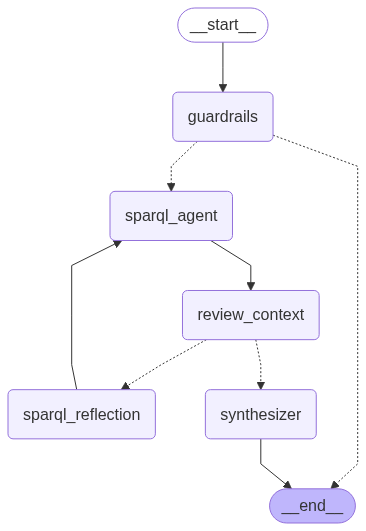

In [55]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not create graph visualization: {e}")

In [56]:
query = "list 10 attack techniques?"
# query = "find me a list of mitigation actions for attack technique Credential Access"

# Query 3: Irrelevant question for Guardrails
# query = "What is the best recipe for fried chicken?"

initial_state = {
    "question": query,
    "original_question": query,
    "messages": [("human", query)],
    "is_context_relevant": None,
    "sparql_iteration_count": 1,
    "max_iterations": 3,
}

config = {"recursion_limit": 15}
final_result = app.invoke(initial_state, config=config)


2025-07-19 12:43:11,264 - __main__ - INFO - --- Executing Node: [[Guardrails]] ---
2025-07-19 12:43:11,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-19 12:43:11,912 - openai._base_client - INFO - Retrying request to /chat/completions in 0.428785 seconds
2025-07-19 12:43:12,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-19 12:43:12,669 - openai._base_client - INFO - Retrying request to /chat/completions in 0.780041 seconds
2025-07-19 12:43:13,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [19]:
print(final_result.get('answer'))

Sorry, I could not find any information related to your question after several attempts.
